In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/CropDataset1.zip /content/


In [ ]:
!unzip /content/CropDataset1.zip

Streaming output truncated to the last 5000 lines.
  inflating: Crop Dataset/PlantVillage/val/Peach___Bacterial_spot/ebdf6ea3-99af-458e-a9fe-cebcf39b0623___Rut._Bact.S 1240.JPG  
  inflating: Crop Dataset/PlantVillage/val/Peach___Bacterial_spot/ec8b301d-6963-4029-80e6-4d8be10104da___Rutg._Bact.S 1273.JPG  
  inflating: Crop Dataset/PlantVillage/val/Peach___Bacterial_spot/ec8c96b1-c9ed-4f95-8445-6a92e1fdee8c___Rut._Bact.S 1215.JPG  
  inflating: Crop Dataset/PlantVillage/val/Peach___Bacterial_spot/ecac2dc3-1a76-4747-97d2-ba9e934c05ac___Rutg._Bact.S 1920.JPG  
  inflating: Crop Dataset/PlantVillage/val/Peach___Bacterial_spot/ecff45a4-3ca8-4d65-a167-3f545933d336___Rutg._Bact.S 1406.JPG  
  inflating: Crop Dataset/PlantVillage/val/Peach___Bacterial_spot/edd30475-0bb8-4249-b479-c1ed901240b0___Rut._Bact.S 1148.JPG  
  inflating: Crop Dataset/PlantVillage/val/Peach___Bacterial_spot/ee659f9d-e80b-4331-a733-2c42208cdfc2___Rut._Bact.S 3350.JPG  
  inflating: Crop Dataset/PlantVillage/val/Peach__

In [ ]:
!git clone https://github.com/NadeemChaudhary16/crop_disease_detection_using_VIT.git

Cloning into 'Image-Classification-Using-Vision-transformer'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 43 (delta 12), reused 8 (delta 8), pack-reused 29
Receiving objects: 100% (43/43), 862.14 KiB | 2.71 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [ ]:
import os
os.chdir('/content/Image-Classification-Using-Vision-transformer')

In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from helper_functions import set_seeds

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head
class_names = ['Apple___Apple_scab',
    'Apple___Black_rot',
    'Apple___Cedar_apple_rust',
    'Apple___healthy',
    'Cherry_(including_sour)___healthy',
    'Cherry_(including_sour)___Powdery_mildew',
    'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
    'Corn_(maize)___Common_rust',
    'Corn_(maize)___healthy',
    'Corn_(maize)___Northern_Leaf_Blight',
    'Grape___Black_rot',
    'Grape___Esca_(Black_Measles)',
    'Grape___healthy',
    'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
    'Peach___Bacterial_spot',
    'Peach___healthy',
    'Pepper,_bell___Bacterial_spot',
    'Pepper,_bell___healthy',
    'Potato___Early_blight',
    'Potato___healthy',
    'Potato___Late_blight',
    'Strawberry___healthy',
    'Strawberry___Leaf_scorch',
    'Tomato___Bacterial_spot',
    'Tomato___Early_blight',
    'Tomato___healthy',
    'Tomato___Late_blight',
    'Tomato___Leaf_Mold',
    'Tomato___Mosaic_virus',
    'Tomato___Septoria_leaf_spot',
    'Tomato___Spider_mites',
    'Tomato___Target_Spot',
    'Tomato___Yellow_Leaf_Curl_Virus']

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 119MB/s]


In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 33]             768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [ ]:
# Setup directory paths to train and test images
train_dir = '/content/Crop Dataset/PlantVillage/train'
test_dir = '/content/Crop Dataset/PlantVillage/val'

In [ ]:
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [ ]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [ ]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if you have more

In [ ]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=12,
                                      device=device)

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4060 | train_acc: 0.9096 | test_loss: 0.1563 | test_acc: 0.9615
Epoch: 2 | train_loss: 0.1141 | train_acc: 0.9712 | test_loss: 0.1060 | test_acc: 0.9718
Epoch: 3 | train_loss: 0.0763 | train_acc: 0.9812 | test_loss: 0.0902 | test_acc: 0.9742
Epoch: 4 | train_loss: 0.0575 | train_acc: 0.9857 | test_loss: 0.0748 | test_acc: 0.9791
Epoch: 5 | train_loss: 0.0463 | train_acc: 0.9883 | test_loss: 0.0740 | test_acc: 0.9774
Epoch: 6 | train_loss: 0.0369 | train_acc: 0.9916 | test_loss: 0.0638 | test_acc: 0.9816
Epoch: 7 | train_loss: 0.0313 | train_acc: 0.9934 | test_loss: 0.0609 | test_acc: 0.9820
Epoch: 8 | train_loss: 0.0267 | train_acc: 0.9938 | test_loss: 0.0602 | test_acc: 0.9808
Epoch: 9 | train_loss: 0.0230 | train_acc: 0.9949 | test_loss: 0.0592 | test_acc: 0.9809
Epoch: 10 | train_loss: 0.0205 | train_acc: 0.9951 | test_loss: 0.0592 | test_acc: 0.9815
Epoch: 11 | train_loss: 0.0174 | train_acc: 0.9965 | test_loss: 0.0572 | test_acc: 0.9826
Epoch: 12 | train_l

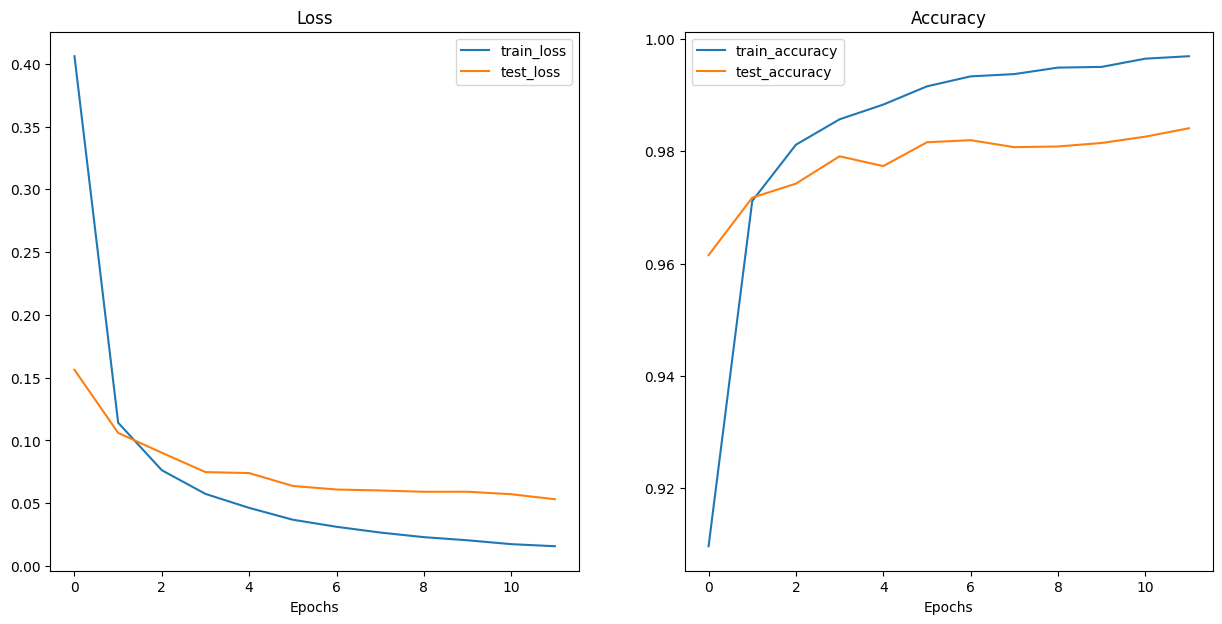

In [ ]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Evaluate the model on the test set
def evaluate_model(model, test_loader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    return y_true, y_pred

# Evaluate the pretrained ViT model
y_true, y_pred = evaluate_model(pretrained_vit, test_dataloader_pretrained, device)

# Calculate evaluation metrics
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_true, y_pred)

# Print the evaluation metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)


Precision: 0.9842
Recall: 0.9841
F1 Score: 0.9841
Confusion Matrix:
[[ 125    0    0 ...    0    0    0]
 [   0  125    0 ...    0    0    0]
 [   0    0   55 ...    0    0    0]
 ...
 [   0    0    0 ...  272    0    1]
 [   0    0    0 ...    0 1065    0]
 [   0    0    0 ...    2    0  314]]


In [ ]:
order=['Apple___Apple_scab',
    'Apple___Black_rot',
    'Apple___Cedar_apple_rust',
    'Apple___healthy',
    'Cherry_(including_sour)___healthy',
    'Cherry_(including_sour)___Powdery_mildew',
    'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
    'Corn_(maize)___Common_rust',
    'Corn_(maize)___healthy',
    'Corn_(maize)___Northern_Leaf_Blight',
    'Grape___Black_rot',
    'Grape___Esca_(Black_Measles)',
    'Grape___healthy',
    'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
    'Peach___Bacterial_spot',
    'Peach___healthy',
    'Pepper,_bell___Bacterial_spot',
    'Pepper,_bell___healthy',
    'Potato___Early_blight',
    'Potato___healthy',
    'Potato___Late_blight',
    'Strawberry___healthy',
    'Strawberry___Leaf_scorch',
    'Tomato___Bacterial_spot',
    'Tomato___Early_blight',
    'Tomato___healthy',
    'Tomato___Late_blight',
    'Tomato___Leaf_Mold',
    'Tomato___Mosaic_virus',
    'Tomato___Septoria_leaf_spot',
    'Tomato___Spider_mites',
    'Tomato___Target_Spot',
    'Tomato___Yellow_Leaf_Curl_Virus']

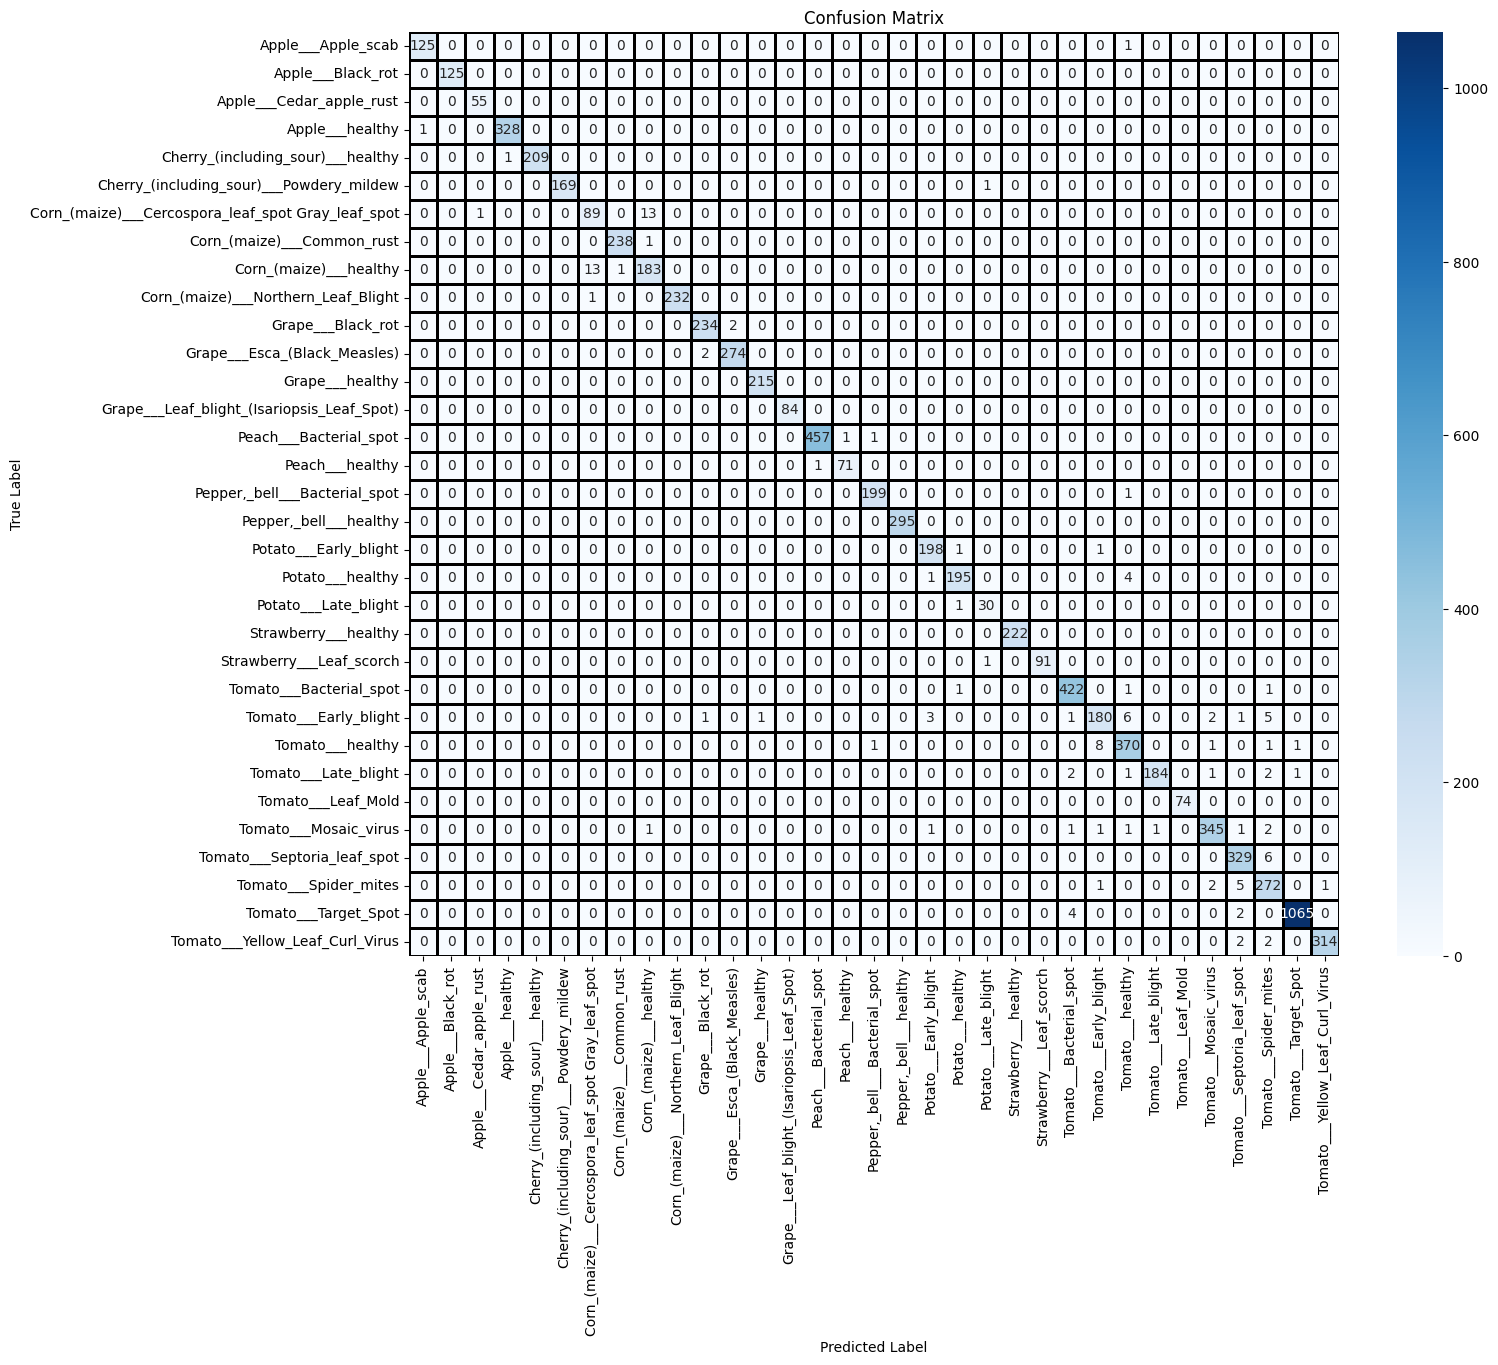

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
cm=confusion_matrix(y_true,y_pred)
fig, ax = plt.subplots(figsize=(15,12))

sns.heatmap(cm, annot=True,fmt='d', cmap='Blues', xticklabels=order, yticklabels=order,linewidths=1,linecolor='black')
plt.title('Confusion Matrix')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

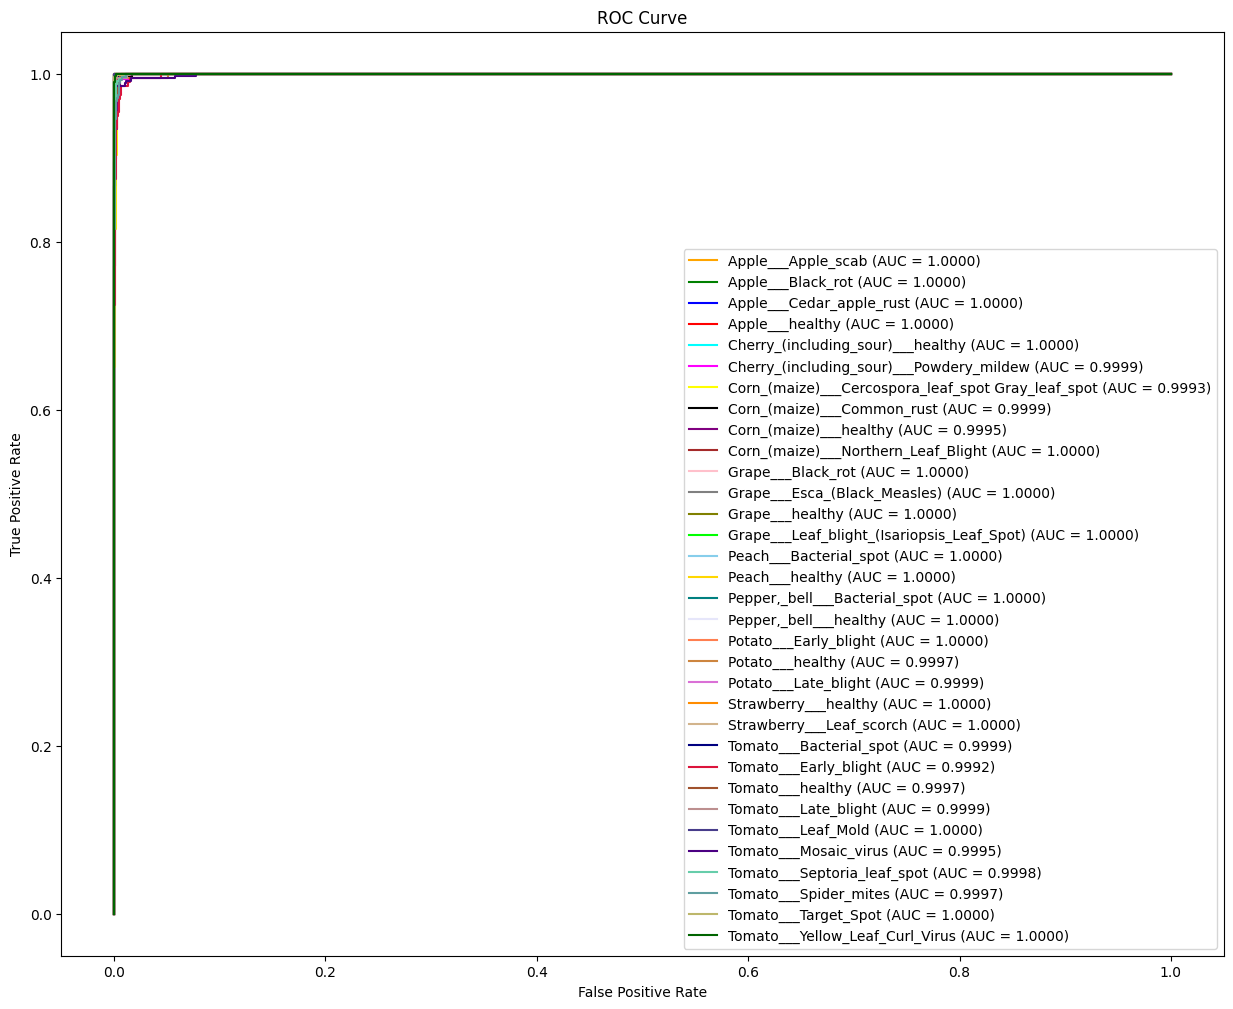

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np  # Importing NumPy and using 'np' as an alias

with torch.no_grad():
    all_probabilities = []
    for images, _ in test_dataloader_pretrained:
        images = images.to(device)
        outputs = pretrained_vit(images)
        probabilities = torch.softmax(outputs, dim=1)
        all_probabilities.extend(probabilities.cpu().numpy())
class_names = [
    'Apple___Apple_scab',
    'Apple___Black_rot',
    'Apple___Cedar_apple_rust',
    'Apple___healthy',
    'Cherry_(including_sour)___healthy',
    'Cherry_(including_sour)___Powdery_mildew',
    'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
    'Corn_(maize)___Common_rust',
    'Corn_(maize)___healthy',
    'Corn_(maize)___Northern_Leaf_Blight',
    'Grape___Black_rot',
    'Grape___Esca_(Black_Measles)',
    'Grape___healthy',
    'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
    'Peach___Bacterial_spot',
    'Peach___healthy',
    'Pepper,_bell___Bacterial_spot',
    'Pepper,_bell___healthy',
    'Potato___Early_blight',
    'Potato___healthy',
    'Potato___Late_blight',
    'Strawberry___healthy',
    'Strawberry___Leaf_scorch',
    'Tomato___Bacterial_spot',
    'Tomato___Early_blight',
    'Tomato___healthy',
    'Tomato___Late_blight',
    'Tomato___Leaf_Mold',
    'Tomato___Mosaic_virus',
    'Tomato___Septoria_leaf_spot',
    'Tomato___Spider_mites',
    'Tomato___Target_Spot',
    'Tomato___Yellow_Leaf_Curl_Virus'
]

class_colors = {
    'Apple___Apple_scab': 'orange',
    'Apple___Black_rot': 'green',
    'Apple___Cedar_apple_rust': 'blue',
    'Apple___healthy': 'red',
    'Cherry_(including_sour)___healthy': 'cyan',
    'Cherry_(including_sour)___Powdery_mildew': 'magenta',
    'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 'yellow',
    'Corn_(maize)___Common_rust': 'black',
    'Corn_(maize)___healthy': 'purple',
    'Corn_(maize)___Northern_Leaf_Blight': 'brown',
    'Grape___Black_rot': 'pink',
    'Grape___Esca_(Black_Measles)': 'gray',
    'Grape___healthy': 'olive',
    'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 'lime',
    'Peach___Bacterial_spot': 'skyblue',
    'Peach___healthy': 'gold',
    'Pepper,_bell___Bacterial_spot': 'teal',
    'Pepper,_bell___healthy': 'lavender',
    'Potato___Early_blight': 'coral',
    'Potato___healthy': 'peru',
    'Potato___Late_blight': 'orchid',
    'Strawberry___healthy': 'darkorange',
    'Strawberry___Leaf_scorch': 'tan',
    'Tomato___Bacterial_spot': 'navy',
    'Tomato___Early_blight': 'crimson',
    'Tomato___healthy': 'sienna',
    'Tomato___Late_blight': 'rosybrown',
    'Tomato___Leaf_Mold': 'darkslateblue',
    'Tomato___Mosaic_virus': 'indigo',
    'Tomato___Septoria_leaf_spot': 'mediumaquamarine',
    'Tomato___Spider_mites': 'cadetblue',
    'Tomato___Target_Spot': 'darkkhaki',
    'Tomato___Yellow_Leaf_Curl_Virus': 'darkgreen'
}

plt.figure(figsize=(15, 12))

for i, class_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve((np.array(y_true) == i).astype(int), np.array(all_probabilities)[:, i])
    roc_auc = roc_auc_score((np.array(y_true) == i).astype(int), np.array(all_probabilities)[:, i])

    color = class_colors.get(class_name, 'black')  # Use a default color if not specified

    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.4f})', color=color)

# plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
# plt.legend()
plt.legend(loc='best')
plt.show()


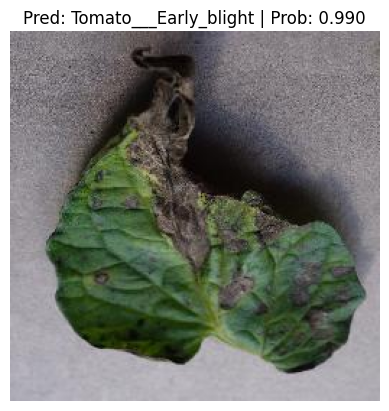

In [ ]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "/content/Crop Dataset/PlantVillage/val/Tomato___Early_blight/0034a551-9512-44e5-ba6c-827f85ecc688___RS_Erly.B 9432.JPG"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

By :
Nadeem Chaudhary